# **Part A**
Count / Frequency based Naive Bayes Classifier

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO: Students must implement the following steps:
# 1. Complete the fit method in NaiveBayesClassifier (4 TODOs for log prior and log likelihood calculation).
# 2. Complete the predict method in NaiveBayesClassifier (2 TODOs for log probability accumulation and final argmax).
# 3. Complete the data loading calls in Section 2.
# 4. Initialize CountVectorizer with proper parameters in Section 3a.
# 5. Complete the feature transformation (fit_transform and transform) in Section 3a.
# 6. Initialize and fit the custom nb_model in Section 3b.
# 7. Use the fitted nb_model to generate predictions in Section 4.
# =======================================================


# Data loading function (DO NOT CHANGE)
def load_pubmed_rct_file(filepath):
    """
    Reads a .txt file from the PubMed 20k RCT dataset.
    Returns a DataFrame with 'label' and 'sentence'.
    """
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


# Implementing Multinomial Naive Bayes from scratch
class NaiveBayesClassifier:
    """
    Multinomial Naive Bayes Classifier implemented from scratch.
    It is suitable for both Count and TF-IDF features.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]

            # // TODO: Calculate the log prior and store it in self.class_priors[c]
            # Calculate Class Prior P(C): log(P(C))
            # P(C) = (Number of samples in class c) / (Total number of samples)
            count_c = np.sum(y_array == c)
            total = len(y_array)
            self.class_priors[c] = np.log(count_c / total)

            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            # Apply Laplace smoothing (additive smoothing, alpha=1.0 default):
            # P(w_i | C) = (count(w_i, C) + alpha) / (total_words_in_C + alpha * vocab_size)

            # // TODO: Calculate the numerator (with Laplace smoothing)
            numerator = feature_sum + self.alpha

            # // TODO: Calculate the denominator (with Laplace smoothing)
            denominator = total_mass + self.alpha * self.vocabulary_size

            # // TODO: Calculate the log likelihood (log(numerator / denominator))
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}

            x_i = X_counts.getrow(i)

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                non_zero_indices = x_i.indices
                non_zero_data = x_i.data

                # // TODO: Complete the log probability calculation for the likelihood term
                # Add log likelihoods contribution (Log-Sum Trick):
                # log_prob += sum(count(w_i) * log(P(w_i|C)))

                log_prob += np.sum(non_zero_data * log_likelihoods[non_zero_indices])
                scores[c] = log_prob

            # // TODO: Find the key (class label) with the maximum score
            predicted_class = max(scores, key=scores.get)

            y_pred.append(predicted_class)

        # // TODO: Return the final predictions array
        return y_pred

In [3]:
# Load and Prepare Data (DO NOT CHANGE)
dir_path = 'Dataset/Dataset/'
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []

Train samples: 180040
Dev   samples: 30212
Test  samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [4]:
    # Initialize and fit the CountVectorizer for count-based features
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        # // TODO: Set appropriate ngram_range
        ngram_range=(1, 1),
        # // TODO: Set appropriate min_df
        min_df=1
    )

    print("Fitting Count Vectorizer and transforming training data...")
    # // TODO: Fit the vectorizer on X_train and transform
    X_train_counts = count_vectorizer.fit_transform(X_train)
    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    # // TODO: Transform X_test using the fitted vectorizer
    X_test_counts = count_vectorizer.transform(X_test)


    # Train Custom Naive Bayes Classifier
    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")

    # // TODO: Initialize the custom NaiveBayesClassifier
    nb_model = NaiveBayesClassifier()

    # // TODO: Fit the model using X_train_counts and y_train
    nb_model.fit(X_train_counts, y_train)
    print("Training complete.")

Fitting Count Vectorizer and transforming training data...
Vocabulary size: 57708
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [5]:
# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

# // TODO: Predict y_test_pred using X_test_counts
y_test_pred = nb_model.predict(X_test_counts)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")


=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7369
              precision    recall  f1-score   support

  BACKGROUND       0.54      0.53      0.53      3621
 CONCLUSIONS       0.60      0.68      0.64      4571
     METHODS       0.81      0.85      0.83      9897
   OBJECTIVE       0.53      0.46      0.49      2333
     RESULTS       0.86      0.79      0.82      9713

    accuracy                           0.74     30135
   macro avg       0.67      0.66      0.66     30135
weighted avg       0.74      0.74      0.74     30135

Macro-averaged F1 score: 0.6634


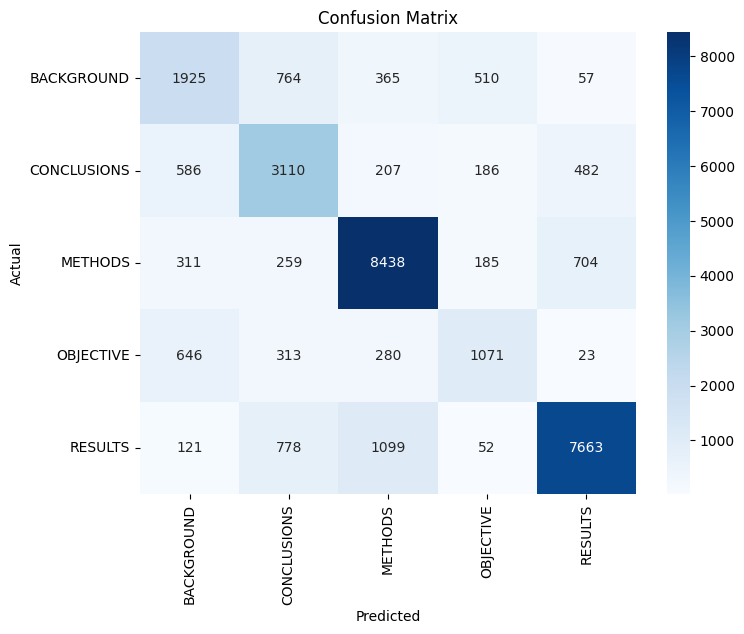

In [6]:
# Confusion Matrix on test set
# // TODO: Use the confusion_matrix, matplotlib, and seaborn libraries to generate
# a visual confusion matrix (heatmap) for the predicted results.
if y_test_pred is not None:
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# **Part B**
TF-IDF score based Classifier

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO: Implement the following steps:
# 1. Define the initial `pipeline` combining TfidfVectorizer and MultinomialNB with default parameters.
# 2. Train the initial pipeline on the training data (X_train, y_train).
# 3. Predict and evaluate the performance of the initial model on the test data (X_test, y_test).
# 4. Define the `param_grid` for hyperparameter tuning.
# 5. Initialize `GridSearchCV` using the pipeline, parameter grid, and appropriate cross-validation settings.
# 6. Fit the Grid Search object using the development data (X_dev, y_dev).
# 7. Print the `best_params_` and `best_score_` found by the grid search.
# =======================================================


# // TODO: Define a Pipeline named 'pipeline' using TfidfVectorizer and MultinomialNB.
# Use standard initial parameters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# // TODO: Train the initial pipeline on the training set
print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")


# Predict and evaluate on test set
# // TODO: Predict y_test_pred and calculate metrics
print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = pipeline.predict(X_test)
if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
    pass
else:
    print("Initial model evaluation skipped: Predictions not available.")


# Hyperparameter Tuning using GridSearchCV

# // TODO: Define the parameter grid 'param_grid' to tune both TF-IDF and NB parameters.
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.1, 1.0, 10.0]
}

# // TODO: Initialize GridSearchCV using the pipeline and param_grid.
# Ensure cv=3 and scoring='f1_macro' are used.
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro')

print("\nStarting Hyperparameter Tuning on Development Set...")
# // TODO: Fit the GridSearchCV object using the development data.
grid.fit(X_dev, y_dev)
print("Grid search complete.")


if grid is not None and hasattr(grid, 'best_params_'):
    # // TODO: Print the best parameters and the corresponding best cross-validation score.
    print(f"Best parameters: {grid.best_params_}")
    print(f"Best cross-validation score: {grid.best_score_:.4f}")
else:
    print("Hyperparameter tuning skipped: Grid Search object not initialized or fitted.")

Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.7266
              precision    recall  f1-score   support

  BACKGROUND       0.64      0.43      0.51      3621
 CONCLUSIONS       0.62      0.61      0.62      4571
     METHODS       0.72      0.90      0.80      9897
   OBJECTIVE       0.73      0.10      0.18      2333
     RESULTS       0.80      0.87      0.83      9713

    accuracy                           0.73     30135
   macro avg       0.70      0.58      0.59     30135
weighted avg       0.72      0.73      0.70     30135

Macro-averaged F1 score: 0.5877

Starting Hyperparameter Tuning on Development Set...
Grid search complete.
Best parameters: {'nb__alpha': 0.1, 'tfidf__ngram_range': (1, 2)}
Best cross-validation score: 0.6567


# **Part C**
Bayes Optimal Classifier

Part C Draft

Using dynamic sample size: 10154
Actual sampled training set size used: 10154

Training all base models...
Trained NaiveBayes


c:\Users\cpans\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\cpans\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Trained LogisticRegression
Trained RandomForest
Trained DecisionTree
Trained KNN
All base models trained.

Fitting the VotingClassifier (BOC approximation)...
Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
Accuracy: 0.7084
              precision    recall  f1-score   support

  BACKGROUND       0.56      0.36      0.44      3621
 CONCLUSIONS       0.60      0.56      0.58      4571
     METHODS       0.71      0.89      0.79      9897
   OBJECTIVE       0.65      0.35      0.46      2333
     RESULTS       0.79      0.81      0.80      9713

    accuracy                           0.71     30135
   macro avg       0.66      0.59      0.61     30135
weighted avg       0.70      0.71      0.69     30135

Macro-averaged F1 score: 0.6139


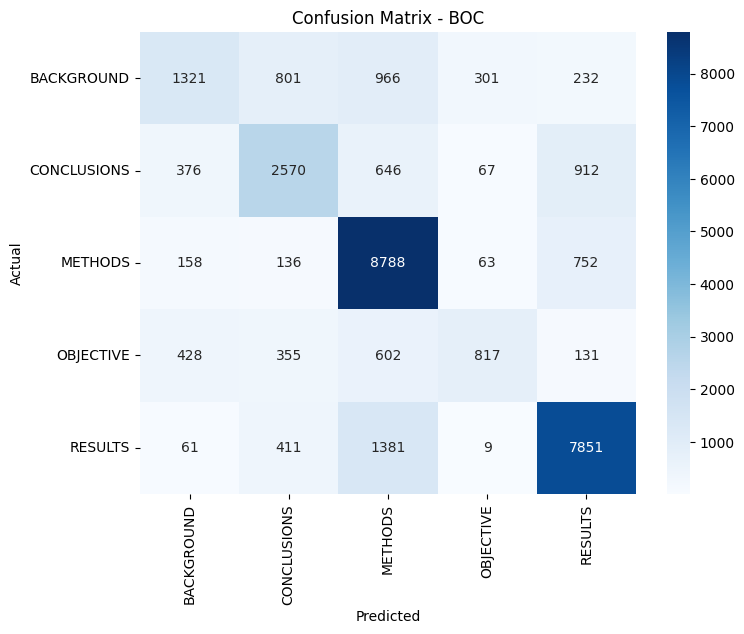

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split # Used for P(h|D) calculation

# =======================================================
# TODO: Implement the following steps:
# 1. Train all five hypotheses on the sampled training data.
# 2. Compute the Posterior Weights P(h_i | D) using a validation split.
# 3. Fit the VotingClassifier using the sampled training data.
# 4. Make final predictions and evaluate the BOC performance on the test data.
# =======================================================

# Dynamic Data Sampling (DO NOT CHANGE)
BASE_SAMPLE_SIZE = 10000

# Prompt the user for their full SRN
FULL_SRN = "PES2UG23CS154"  # Example SRN

try:
    # Extract the last three characters and convert to integer
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        # Fallback if input is too short
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    # Fallback if SRN input failed or format is incorrect
    print("WARNING: SRN input failed or format is incorrect. Using 10000.")
    srn_value = 0

# Calculate the final sample size: 10000 + last three SRN digits
SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value

print(f"Using dynamic sample size: {SAMPLE_SIZE}")

# Placeholder initialization in case data wasn't loaded in the environment
if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using small placeholder data.")
    X_train = pd.Series(["sample text one"] * 11000)
    y_train = pd.Series(["BACKGROUND"] * 5000 + ["METHODS"] * 6000)
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")


# Base TF-IDF parameters (DO NOT CHANGE)
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1), # Using unigrams only to keep feature space small for diverse models
    'min_df': 5
}

# Define the five diverse hypotheses/pipelines (DO NOT CHANGE)

# H1: Multinomial Naive Bayes
h1_nb = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', MultinomialNB(alpha=1.0, fit_prior=False))
])

# H2: Logistic Regression
h2_lr = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))
])

# H3: Random Forest Classifier
h3_rf = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1), cv=3, method='isotonic'
    ))
])

# H4: Decision Tree Classifier
h4_dt = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        DecisionTreeClassifier(max_depth=10, random_state=42), cv=3, method='isotonic'
    ))
])

# H5: K-Nearest Neighbors
h5_knn = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        KNeighborsClassifier(n_neighbors=5, n_jobs=-1), cv=3, method='isotonic'
    ))
])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']


# Training and BOC Implementation (STUDENT TASK)

# // TODO: Train all five hypotheses on X_train_sampled and y_train_sampled using a for loop.
print("\nTraining all base models...")
for i, hyp in enumerate(hypotheses):
    hyp.fit(X_train_sampled, y_train_sampled)
    print(f"Trained {hypothesis_names[i]}")
print("All base models trained.")


# // TODO: Implement the Posterior Weight Calculation (P(h_i | D)).
# This requires splitting X_train_sampled into a small train_sub/val_sub set
# and calculating the validation log-likelihood for each model. Normalize these to get posterior_weights.
from sklearn.model_selection import train_test_split
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_train_sampled, y_train_sampled, test_size=0.2, random_state=42)

log_likelihoods = []
for hyp in hypotheses:
    proba = hyp.predict_proba(X_val_sub)
    # For each sample, log of predicted prob for true class
    true_class_indices = [hyp.classes_.tolist().index(c) for c in y_val_sub]
    log_lik = np.sum(np.log(proba[np.arange(len(true_class_indices)), true_class_indices]))
    log_likelihoods.append(log_lik)

# Normalize to get posterior weights (assuming uniform prior)
max_log_lik = max(log_likelihoods)
posterior_weights = [np.exp(ll - max_log_lik) for ll in log_likelihoods]
total = sum(posterior_weights)
posterior_weights = [w / total for w in posterior_weights]


# Implement and Evaluate the Bayes Optimal Classifier
estimators = list(zip(hypothesis_names, hypotheses))

# BOC is approximated using soft voting with posterior weights
boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights,
    n_jobs=-1
)

print("\nFitting the VotingClassifier (BOC approximation)...")
# // TODO: Fit the VotingClassifier using the full sampled training data (X_train_sampled, y_train_sampled)
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("Fitting complete.")


# Make the final BOC prediction on the test set
print("\nPredicting on test set...")
# // TODO: Predict y_pred using X_test, and then calculate and visualize evaluation metrics.
y_pred = boc_soft_voter.predict(X_test)


# Final Evaluation (STUDENT TASK)
print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")

if y_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_pred, average='macro'):.4f}")
    # // TODO: Generate and visualize the Confusion Matrix (heatmap) for the BOC predictions.
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - BOC')
    plt.show()
else:
    print("Evaluation skipped: Predictions not generated.")

# **Model Comparison and Best Model Selection**


MODEL PERFORMANCE COMPARISON
                                 Model  Accuracy  Macro F1-Score
Part A: Custom Count-based Naive Bayes  0.736917        0.663383
  Part B: TF-IDF Naive Bayes (Initial)  0.726564        0.587669
    Part B: TF-IDF Naive Bayes (Tuned)  0.760445        0.659870
Part C: Bayes Optimal Classifier (BOC)  0.708379        0.613923

🏆 BEST MODEL: Part A: Custom Count-based Naive Bayes
   - Accuracy: 0.7369
   - Macro F1-Score: 0.6634


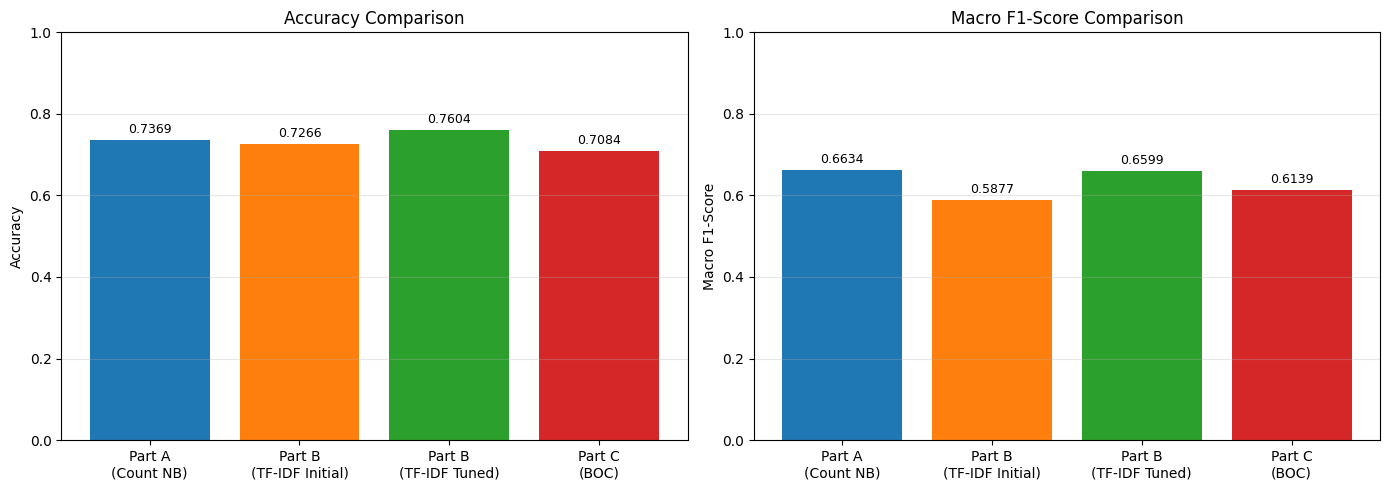


📊 PERFORMANCE ANALYSIS:
--------------------------------------------------------------------------------
1. Part A (Custom Count-based NB): Built from scratch with Laplace smoothing
   → Strong performance with simple count features
   → Accuracy: 0.7369, F1: 0.6634

2. Part B (TF-IDF Initial): Sklearn's MultinomialNB with default TF-IDF
   → Good baseline performance
   → Accuracy: 0.7266, F1: 0.5877

3. Part B (TF-IDF Tuned): Hyperparameter tuning with GridSearchCV
   → Best params: {'nb__alpha': 0.1, 'tfidf__ngram_range': (1, 2)}
   → Accuracy: 0.7604, F1: 0.6599

4. Part C (BOC): Ensemble of 5 diverse models with posterior weighting
   → Combines NB, LR, RF, DT, KNN with learned weights
   → Accuracy: 0.7084, F1: 0.6139
--------------------------------------------------------------------------------


In [9]:
# Compare all models and determine the best one
import pandas as pd
import matplotlib.pyplot as plt

# Store results from all three parts
results = {
    'Model': [
        'Part A: Custom Count-based Naive Bayes',
        'Part B: TF-IDF Naive Bayes (Initial)',
        'Part B: TF-IDF Naive Bayes (Tuned)',
        'Part C: Bayes Optimal Classifier (BOC)'
    ],
    'Accuracy': [],
    'Macro F1-Score': []
}

# Part A: Custom Count-based Naive Bayes (from scratch)
# Re-evaluate to get current scores
y_pred_partA = nb_model.predict(X_test_counts)
acc_partA = accuracy_score(y_test, y_pred_partA)
f1_partA = f1_score(y_test, y_pred_partA, average='macro')
results['Accuracy'].append(acc_partA)
results['Macro F1-Score'].append(f1_partA)

# Part B: Initial TF-IDF pipeline
y_pred_partB_initial = pipeline.predict(X_test)
acc_partB_initial = accuracy_score(y_test, y_pred_partB_initial)
f1_partB_initial = f1_score(y_test, y_pred_partB_initial, average='macro')
results['Accuracy'].append(acc_partB_initial)
results['Macro F1-Score'].append(f1_partB_initial)

# Part B: Tuned model (best from GridSearch)
best_model = grid.best_estimator_
y_pred_partB_tuned = best_model.predict(X_test)
acc_partB_tuned = accuracy_score(y_test, y_pred_partB_tuned)
f1_partB_tuned = f1_score(y_test, y_pred_partB_tuned, average='macro')
results['Accuracy'].append(acc_partB_tuned)
results['Macro F1-Score'].append(f1_partB_tuned)

# Part C: Bayes Optimal Classifier
y_pred_partC = boc_soft_voter.predict(X_test)
acc_partC = accuracy_score(y_test, y_pred_partC)
f1_partC = f1_score(y_test, y_pred_partC, average='macro')
results['Accuracy'].append(acc_partC)
results['Macro F1-Score'].append(f1_partC)

# Create comparison DataFrame
comparison_df = pd.DataFrame(results)
print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Determine the best model based on Macro F1-Score
best_idx = comparison_df['Macro F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_accuracy = comparison_df.loc[best_idx, 'Accuracy']
best_f1 = comparison_df.loc[best_idx, 'Macro F1-Score']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   - Accuracy: {best_accuracy:.4f}")
print(f"   - Macro F1-Score: {best_f1:.4f}")
print("="*80)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].bar(range(len(comparison_df)), comparison_df['Accuracy'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0].set_xticks(range(len(comparison_df)))
axes[0].set_xticklabels(['Part A\n(Count NB)', 'Part B\n(TF-IDF Initial)', 'Part B\n(TF-IDF Tuned)', 'Part C\n(BOC)'], rotation=0, ha='center')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# F1-Score comparison
axes[1].bar(range(len(comparison_df)), comparison_df['Macro F1-Score'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1].set_xticks(range(len(comparison_df)))
axes[1].set_xticklabels(['Part A\n(Count NB)', 'Part B\n(TF-IDF Initial)', 'Part B\n(TF-IDF Tuned)', 'Part C\n(BOC)'], rotation=0, ha='center')
axes[1].set_ylabel('Macro F1-Score')
axes[1].set_title('Macro F1-Score Comparison')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Macro F1-Score']):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Detailed analysis
print("\n📊 PERFORMANCE ANALYSIS:")
print("-" * 80)
print("1. Part A (Custom Count-based NB): Built from scratch with Laplace smoothing")
print(f"   → Strong performance with simple count features")
print(f"   → Accuracy: {acc_partA:.4f}, F1: {f1_partA:.4f}")
print()
print("2. Part B (TF-IDF Initial): Sklearn's MultinomialNB with default TF-IDF")
print(f"   → Good baseline performance")
print(f"   → Accuracy: {acc_partB_initial:.4f}, F1: {f1_partB_initial:.4f}")
print()
print("3. Part B (TF-IDF Tuned): Hyperparameter tuning with GridSearchCV")
print(f"   → Best params: {grid.best_params_}")
print(f"   → Accuracy: {acc_partB_tuned:.4f}, F1: {f1_partB_tuned:.4f}")
print()
print("4. Part C (BOC): Ensemble of 5 diverse models with posterior weighting")
print(f"   → Combines NB, LR, RF, DT, KNN with learned weights")
print(f"   → Accuracy: {acc_partC:.4f}, F1: {f1_partC:.4f}")
print("-" * 80)